In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#Prove data can be read; commented out b/ done in cell below
#cleveland_csv <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")
#cleveland_csv

In [3]:
#Clean and Wrangle Data
cleveland_clean <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                            col_names=c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")) |>
                    mutate(if_hd = as.character(num)) |>
                    select(age, chol, trestbps, thalach, if_hd)

cleveland_clean["if_hd"][cleveland_clean["if_hd"] == 0, na.rm=TRUE] <- "No"
cleveland_clean["if_hd"][cleveland_clean["if_hd"] != "No", na.rm=TRUE] <- "Yes"

cleveland_clean

#NA Data Test (ALL DATA)
data_count <- count(cleveland_clean)
data_count_NA <- cleveland_clean |> 
    na.omit() |>
    count()

na <- data_count - data_count_NA 
na

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,chol,trestbps,thalach,if_hd
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
63,233,145,150,No
67,286,160,108,Yes
67,229,120,129,Yes
⋮,⋮,⋮,⋮,⋮
57,131,130,115,Yes
57,236,130,174,Yes
38,175,138,173,No


n
<int>
0


In [4]:
#Create Training Set and Testing Set
data_split <- initial_split(cleveland_clean, prop = 0.75, strata = if_hd)
cleveland_train <- training(data_split)  
cleveland_test <- testing(data_split)

In [5]:
#Mean Values
cleveland_mean <- cleveland_train |>
    select(-if_hd) |>
    map_df(mean, na.rm=TRUE) |>
    pivot_longer(cols= age:thalach,
                names_to= "predictor", 
                values_to = "mean")

#Max Values
cleveland_max <- cleveland_train |>
    select(-if_hd) |>
    map_df(max, na.rm=TRUE)|>
    pivot_longer(cols= age:thalach,
                names_to= "predictor", 
                values_to = "max")

#Min Values
cleveland_min <- cleveland_train |>
    select(-if_hd) |>
    map_df(min, na.rm=TRUE) |>
    pivot_longer(cols= age:thalach,
                names_to= "predictor", 
                values_to = "min")

#How many values have/ don't have heart disease, and total data values
cleveland_yesvsno <- cleveland_train |>
    group_by(if_hd) |>
    summarize(n=n())|>
    pivot_wider(names_from = if_hd, values_from = n) |>
    mutate(total_data = Yes + No) |>
    select(Yes, No, total_data)
colnames(cleveland_yesvsno) <- paste0(list("with_hd", "without_hd", "total_data"))

#Number of NAs
data_count <- count(cleveland_train)
NA_training <- cleveland_train |> 
    na.omit() |>
    count()
na <- data_count - NA_training
colnames(na) <- paste0("number_of_NA")

#Merging of above data into two graphs
cleveland_count <- Reduce(merge, list(cleveland_yesvsno, na))
cleveland_count

cleveland_merge_df <- Reduce(merge, list(cleveland_mean, cleveland_max, cleveland_min))
cleveland_merge_df

with_hd,without_hd,total_data,number_of_NA
<int>,<int>,<int>,<int>
104,123,227,0


predictor,mean,max,min
<chr>,<dbl>,<dbl>,<dbl>
age,53.84581,76,29
chol,243.32599,417,131
thalach,150.50220,202,90
trestbps,131.96916,200,94


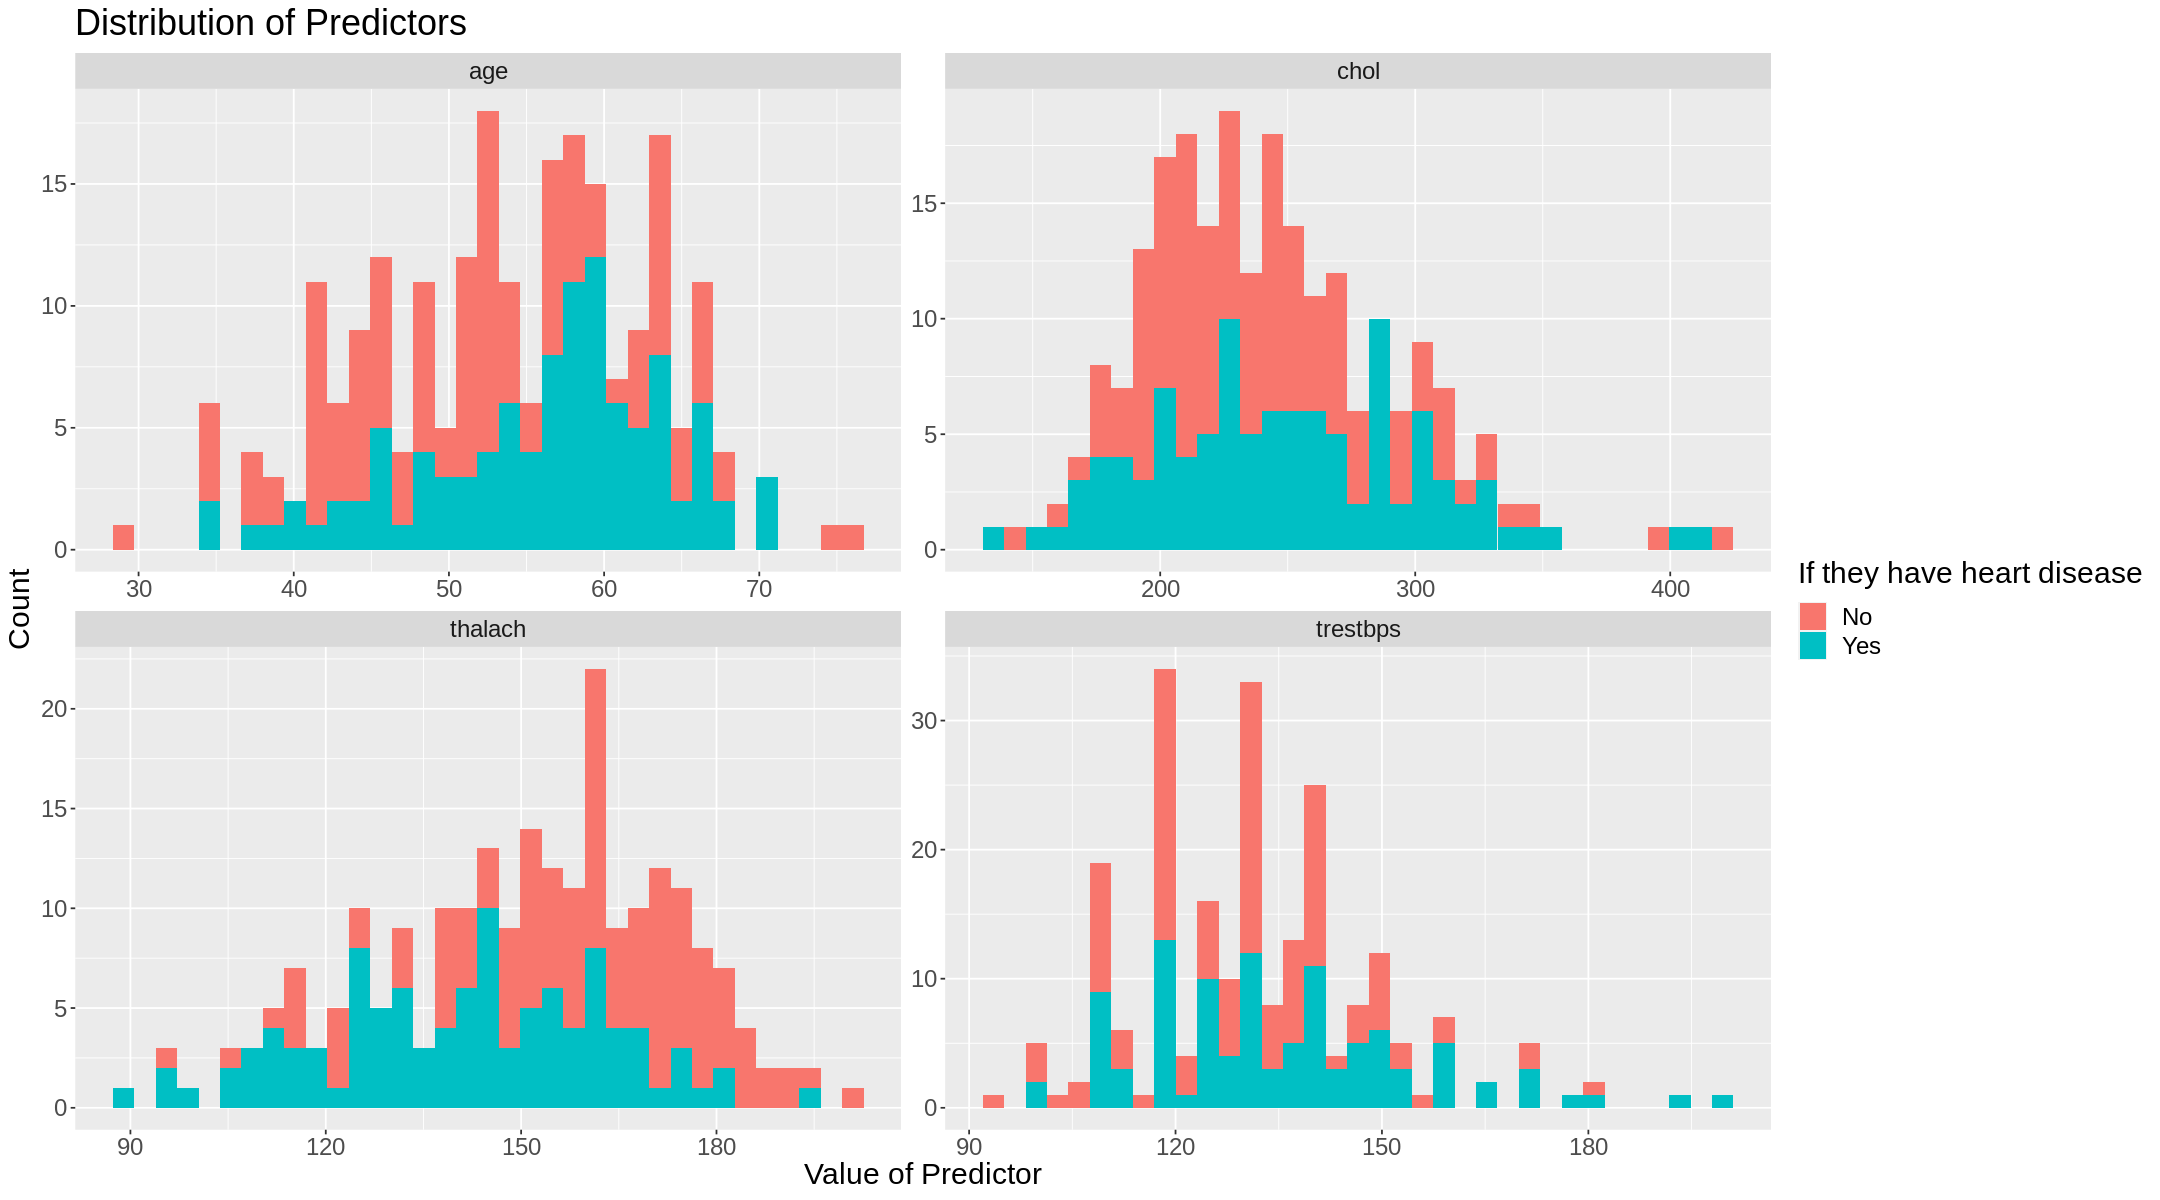

In [6]:
options(repr.plot.width = 18, repr.plot.height = 10)

#Fix data for facet_wrap
cleveland_plot_data <- cleveland_train |> 
    pivot_longer(cols = age:thalach, names_to = "parameter", values_to = "value")

#Plot
cleveland_plot <- ggplot(cleveland_plot_data, aes(x=value, fill = if_hd)) +
    geom_histogram(bins=35) +
    facet_wrap(parameter ~ . ,scales = "free") +
    labs(x= "Value of Predictor", y="Count", fill = "If they have heart disease") +
    ggtitle("Distribution of Predictors") +
    theme(text = element_text(size=18))

cleveland_plot